In [1]:
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from tqdm import tqdm
from operator import itemgetter
import itertools



$R = 6371000 \, \text{meters} \quad \text{(radius of the Earth)}$

$\phi = \text{latitude in radians}$

$\lambda = \text{longitude in radians}$

The Earth-Centered Earth-Fixed (ECEF) coordinates are given by:

$X = R \cos(\phi) \cos(\lambda)$

$Y = R \cos(\phi) \sin(\lambda)$ 

$Z = R \sin(\phi)$

In [2]:
R_E = 6378 # km
# J2000 epoch
J2000 = datetime.datetime(2000, 1, 1, 12, 0, 0)
ERA_J2000 = 280.46
gamma=360.9856123035484

def latlong2ecef(latlong):
    lat_deg, lon_deg = latlong
    lat_rad = np.deg2rad(lat_deg)
    lon_rad = np.deg2rad(lon_deg)

    X = R_E * np.cos(lat_rad) * np.cos(lon_rad)
    Y = R_E * np.cos(lat_rad) * np.sin(lon_rad)
    Z = R_E * np.sin(lat_rad)

    return np.array([X, Y, Z])

def rotmat_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

def ecef2eci(ecef, time):
    time_difference = time - J2000
    days_difference = time_difference.total_seconds() / (24 * 60 * 60)
    theta = np.deg2rad((ERA_J2000 + gamma * days_difference) % 360)
    rot_mat = rotmat_z(theta)
    return np.dot(rot_mat, ecef)

def eci2ecef(eci, time):
    time_difference = time - J2000
    days_difference = time_difference.total_seconds() / (24 * 60 * 60)
    theta = np.deg2rad((ERA_J2000 + gamma * days_difference) % 360)
    rot_mat = rotmat_z(-theta)
    return np.dot(rot_mat, eci)

def ecef2latlong(ecef):
    X, Y, Z = ecef
    lat = np.arcsin(Z / np.linalg.norm(ecef))
    lon = np.arctan2(Y, X)
    return np.array([np.rad2deg(lat), np.rad2deg(lon)])

def ecef2eci_vec(ecef, time):
    # Ensure ecef is a NumPy array
    ecef = np.asarray(ecef)
    
    # Check the shape of ecef
    if ecef.ndim != 2 or ecef.shape[1] != 3:
        raise ValueError("ecef must be a 2D array with shape (N, 3)")
    
    time_difference = time - J2000
    days_difference = time_difference.total_seconds() / (24 * 60 * 60)
    
    # Calculate the rotation angle theta in radians
    theta_deg = (ERA_J2000 + gamma * days_difference) % 360
    theta = np.deg2rad(theta_deg)
    
    # Compute the rotation matrix
    rot_mat = rotmat_z(theta)  # Shape: (3, 3)
    
    # Apply the rotation matrix to all ECEF coordinates
    # Using matrix multiplication: (N, 3) @ (3, 3).T -> (N, 3)
    eci = ecef @ rot_mat.T
    
    return eci

def latlong2ecef_vec(latlong):
    lat_deg = latlong[:, 0]
    lon_deg = latlong[:, 1]
    
    # Convert degrees to radians
    lat_rad = np.deg2rad(lat_deg)
    lon_rad = np.deg2rad(lon_deg)
    
    # Compute ECEF coordinates
    cos_lat = np.cos(lat_rad)
    sin_lat = np.sin(lat_rad)
    cos_lon = np.cos(lon_rad)
    sin_lon = np.sin(lon_rad)
    
    X = R_E * cos_lat * cos_lon
    Y = R_E * cos_lat * sin_lon
    Z = R_E * sin_lat
    
    # Stack into a (N, 3) array
    ecef = np.column_stack((X, Y, Z))
    
    return ecef

# Generate tasks in lat/long coordinates
task = np.array([51.6, 0]) # Latitude, Longitude
task_ecef = latlong2ecef(task)
task_eci = ecef2eci(task_ecef, datetime.datetime.now())
print(task_eci) 


[ 3638.82506371 -1566.48168756  4998.39687082]


In [3]:
from collections import namedtuple

# Define a namedtuple for Keplerian elements
Keplerian = namedtuple('Keplerian', ['a', 'e', 'i', 'omega', 'Omega', 'M'])

# Six keplerian elements: a, e, i, omega, Omega, M
def kepler2eci(elements: tuple) -> tuple:
    a, e, i, omega, Omega, M = elements
    mu = 398600.4418  # Earth's gravitational parameter, km^3/s^2
    nu = None
    r = None
    if(e != 0):
        # Solve Kepler's Equation for E (Eccentric Anomaly)
        E = M
        error = 1
        while error > 1e-6:
            E_new = M + e * np.sin(E)
            error = np.abs(E_new - E)
            E = E_new
    
        # True anomaly
        nu = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))
        # Distance (radius) from the central body
        r = a * (1 - e * np.cos(E))
    else:
        nu = M
        r = a

    # Position in the perifocal coordinate system
    r_perifocal = np.array([r * np.cos(nu), r * np.sin(nu), 0])
    
    # Velocity in the perifocal coordinate system
    h = np.sqrt(mu * a * (1 - e**2))
    v_perifocal = np.array([-mu / h * np.sin(nu), mu / h * (e + np.cos(nu)), 0])

    # Rotation matrices
    R_Omega = np.array([
        [np.cos(Omega), -np.sin(Omega), 0],
        [np.sin(Omega), np.cos(Omega), 0],
        [0, 0, 1]
    ])
    R_i = np.array([
        [1, 0, 0],
        [0, np.cos(i), -np.sin(i)],
        [0, np.sin(i), np.cos(i)]
    ])
    R_omega = np.array([
        [np.cos(omega), -np.sin(omega), 0],
        [np.sin(omega), np.cos(omega), 0],
        [0, 0, 1]
    ])

    # Complete rotation matrix from perifocal to ECI
    R = R_Omega @ R_i @ R_omega

    # Position and velocity in the ECI frame
    r_eci = R @ r_perifocal
    v_eci = R @ v_perifocal

    return r_eci, v_eci

# Generate a circular orbit
def circular_orbit(a: float, i: float, Omega: float, M: float):
    return Keplerian(a, 0, i, 0, Omega, M)

def propagate_orbit(orbit: Keplerian, time: float):
    mu = 398600.4418 # km^3/s^2
    a, e, i, omega, Omega, M = orbit
    n = np.sqrt(mu / a**3)
    M_new = M + n * time
    return Keplerian(a, e, i, omega, Omega, M_new)

# First... probably should make a visualizer for it
t_0 = datetime.datetime(2024, 1, 1, 0, 0, 0)
t_end = datetime.datetime(2024, 1, 1, 1, 0, 0)
orbit = propagate_orbit(circular_orbit(a=R_E+400, i=np.deg2rad(45), Omega=0, M=0), (t_0 - J2000).total_seconds())
task = np.array([51.6, 0]) # Latitude, Longitude

task_eci = ecef2eci(latlong2ecef(task), t_0)
orbit_eci = kepler2eci(orbit)[0]

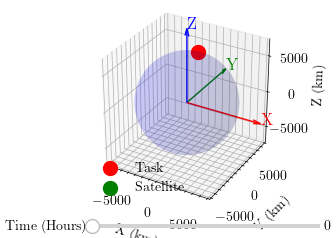

In [4]:
from matplotlib import animation
from matplotlib.widgets import Slider

%matplotlib widget
# Create a figure and axis for the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize the plot with Earth as a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = R_E * np.outer(np.cos(u), np.sin(v))
y = R_E * np.outer(np.sin(u), np.sin(v))
z = R_E * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1, zorder=-1)

# Plot task on the surface of the Earth (this doesn't change over time)
task_eci = ecef2eci(latlong2ecef(task), t_0)
task_point = ax.scatter(task_eci[0], task_eci[1], task_eci[2], color='r', s=100, label="Task", zorder=0)

# Create a scatter object for the satellite, which will be updated during animation
satellite_point = ax.scatter([], [], [], color='g', s=100, label="Satellite")

ax.quiver(0, 0, 0, 1e4, 0, 0, color='r', arrow_length_ratio=0.1)  # x-axis in red
ax.quiver(0, 0, 0, 0, 1e4, 0, color='g', arrow_length_ratio=0.1)  # y-axis in green
ax.quiver(0, 0, 0, 0, 0, 1e4, color='b', arrow_length_ratio=0.1)  # z-axis in blue

ax.text(1e4, 0, 0, 'X', color='r', fontsize=12)  # x-axis label
ax.text(0, 1e4, 0, 'Y', color='g', fontsize=12)  # y-axis label
ax.text(0, 0, 1e4, 'Z', color='b', fontsize=12)  # z-axis label

# Set labels and plot parameters
ax.set_aspect('equal')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
# ax.set_title('Satellite Orbit and Task on Earth Surface')
ax.legend()


# Define initial time delta in seconds
initial_seconds = 0

# Define the update function for the animation
def update_satellite(seconds_since_epoch):
    global satellite_point
    orbit = propagate_orbit(circular_orbit(a=R_E+400, i=np.deg2rad(45), Omega=0, M=0), seconds_since_epoch)
    orbit_eci = kepler2eci(orbit)[0]
    # Make sure to pass the positions as single-element arrays
    satellite_point._offsets3d = ([orbit_eci[0]], [orbit_eci[1]], [orbit_eci[2]])
    return satellite_point,

def update_task(seconds_since_epoch):
    global task_point
    task_eci = ecef2eci(latlong2ecef(task), t_0 + datetime.timedelta(seconds=seconds_since_epoch))
    # Make sure to pass the positions as single-element arrays
    task_point._offsets3d = ([task_eci[0]], [task_eci[1]], [task_eci[2]])
    return satellite_point,
# Function to be called when the slider is changed
def update(val):
    seconds_since_epoch = (t_0 - J2000).total_seconds() + slider.val * 3600  # Slider controls hours
    update_satellite(seconds_since_epoch)
    update_task(seconds_since_epoch)
    fig.canvas.draw_idle()

# Set up slider
slider_ax = plt.axes([0.25, 0.02, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(slider_ax, 'Time (Hours)', 0, 6, valinit=0, valstep=0.1)

# Attach the slider update function
slider.on_changed(update)

# Call the update function for animation
# ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 6 * 3600, 600), interval=50, blit=False, )

plt.show()

In [20]:
mu = 398600
h = 400
field_of_regard = 30 # degrees
days_in_year = 365.2422 # TODO: check

def v_orb(h):
    return np.sqrt(mu / (h + 6378.1))

t_coarse = 100 # seconds
v = v_orb(h)
filter_radius = np.sqrt((v * t_coarse/2)**2 + (h ** 2) * (1 + np.sin(np.deg2rad(field_of_regard))**2))
print(f"filter radius: {filter_radius}")
# Find better filter radius
theta = np.arctan((h * np.tan(np.deg2rad(field_of_regard))) / R_E)
theta_total = theta + np.deg2rad((gamma / (24 * 3600)) * t_coarse)
filter_radius_improved = np.sqrt((v * t_coarse/2)**2 + (h + R_E * (1 - np.cos(theta_total)))**2 + (R_E * np.sin(theta_total))**2)
print(f"filter radius improved: {filter_radius_improved}")
filter_radius = filter_radius_improved 

# Task generation algorithm
# 0. Filter requests within radius
# 1: Increment macro time (1 minute?)
# 2: Generate new filtered requests within radius (radius min defined as min of horizon distance)
# 3. If they are signed oppositely, use binary searcb to find the closest point
# Use signed distance (x - r).dot(v)/||v|| to find the closest point
# 4. Log time of request and angle, generate as new request

orbit = circular_orbit(a=R_E+h, i=np.deg2rad(45), Omega=0, M=0)
# tasks = np.array([[40, 0]]) # Latitude, Longitude

request = namedtuple('Request', ['id', 'lat', 'long', 'name'])
task = namedtuple('Task', ['requestid', 'lat', 'long', 'name', 'time', 'angle'])

# Generate random requests...
np.random.seed(2)
# requests = [request(i, np.random.uniform(-90, 90), np.random.uniform(-180, 180), f"Request {i}") for i in range(100)]
# requests = [request(0, 40, 0, 'test1'), request(1, 85, -5, 'test2')]
# requests = [request(i, i * 86/49, 0, f"Request {i}") for i in range(100)]

# Load world cities requests...
requests = []
# Open the CSV and process the lines
with open('../../data/worldcities/worldcities.csv', 'r', encoding='utf8') as f:
    f.readline()  # Skip the header line
    i = 0
    for line in f:
        parts = re.split(r'(?:",")|"', line)
        # Extract the latitude, longitude, and city name
        lat = float(parts[3])
        lon = float(parts[4])
        city = parts[2]
        # Create a new Request object and append it to the list
        requests.append(request(len(requests), lat, lon, city))
        i += 1
        if i >= 10000:
            break

seconds_since_epoch = 0 #(t_0 - J2000).total_seconds()

def dist(x, y):
    return np.linalg.norm(x - y, axis=1)

def dist2plane(r, n, p):
    return ((p - r).dot(n) / np.linalg.norm(n))

def multi_async_dispatch_search(requests, req_latlongs, t1, t2, r1, r2, d1, d2, orbit):
    t3 = (t1 + t2) / 2
    # 1 second threshold
    if(t2 - t1 < 1):
        tasks = []
        for i, x in enumerate(requests):
            # Check access constraints...
            # Propagate to position
            task_eci = ecef2eci(latlong2ecef((x.lat, x.long)), t_0 + datetime.timedelta(seconds=t3 - seconds_since_epoch))
            r, v = kepler2eci(propagate_orbit(orbit, t1))
            # Compute the angle using dot product
            angle_diff = np.arccos(np.dot(r, r - task_eci) / (np.linalg.norm(r) * np.linalg.norm(task_eci - r)))
            sign = np.sign(dist2plane(r, np.cross(r, v), task_eci))   
            angle_diff = np.rad2deg(angle_diff) * sign
            if(np.abs(angle_diff) < field_of_regard ):
                tasks.append(task(x.id, x.lat, x.long, x.name, t_0 + datetime.timedelta(seconds=t3 - seconds_since_epoch), angle_diff))
        
        return tasks
    
    # Assume all tasks change sign in this time period
    r3, v3 = kepler2eci(propagate_orbit(orbit, t3))

    tasks_eci_3 = ecef2eci_vec(latlong2ecef_vec(req_latlongs), t_0 + datetime.timedelta(seconds=t3 - seconds_since_epoch)) 

    d3 = dist2plane(r3, v3, tasks_eci_3)

    filter_firsthalf = d1 * d3 < 0
    filter_secondhalf = d2 * d3 < 0

    tasks_firsthalf = [requests[i] for i in range(len(requests)) if filter_firsthalf[i]]
    tasks_secondhalf = [requests[i] for i in range(len(requests)) if filter_secondhalf[i]]

    task_times_1 = []
    task_times_2 = []

    # Split and recurse
    if(len(tasks_firsthalf) > 0):
        task_times_1 = multi_async_dispatch_search(tasks_firsthalf, req_latlongs[filter_firsthalf], t1, t3, r1, r3, d1[filter_firsthalf], d3[filter_firsthalf], orbit)

    if(len(tasks_secondhalf) > 0):
        task_times_2 = multi_async_dispatch_search(tasks_secondhalf, req_latlongs[filter_secondhalf], t3, t2, r3, r2, d3[filter_secondhalf], d2[filter_secondhalf], orbit)
    
    return task_times_1 + task_times_2

def get_total_tasks():
    total_tasks = []

    req_latlongs = np.array([[x.lat, x.long] for x in requests])

    r1, v1 = kepler2eci(propagate_orbit(orbit, seconds_since_epoch ))
    for i in tqdm(range(0, int(1 * 1 * 3600) - t_coarse, t_coarse)):
        t1 = seconds_since_epoch + i
        t2 = seconds_since_epoch + i + t_coarse
        
        # Calculate ECI points 
        r2, v2 = kepler2eci(propagate_orbit(orbit, t2))

        tasks_eci_1 = ecef2eci_vec(latlong2ecef_vec(req_latlongs), t_0 + datetime.timedelta(seconds=i)) 
        tasks_eci_2 = ecef2eci_vec(latlong2ecef_vec(req_latlongs), t_0 + datetime.timedelta(seconds=i + t_coarse)) 

        task_dists_1 = dist(r1, tasks_eci_1) 
        task_dists_2 = dist(r2, tasks_eci_2) 
        # print(task_dists_1)
        # orbit_latlong = np.array(ecef2latlong(eci2ecef(kepler2eci(propagate_orbit(orbit, t2))[0], t_0 + datetime.timedelta(seconds=i + t_coarse))))
        # print(orbit_latlong)
        task_mask = (task_dists_1 <= filter_radius) + (task_dists_2 <= filter_radius)

        if(np.sum(task_mask) > 0):
            requests_prefiltered = list(itertools.compress(requests, task_mask))
            req_latlongs_prefiltered = list(itertools.compress(req_latlongs, task_mask))

            d1 = dist2plane(r1, v1, tasks_eci_1[task_mask])
            d2 = dist2plane(r2, v2, tasks_eci_2[task_mask])
            
            requests_crossindex = [d1[i] * d2[i] < 0 and d1[i] > d2[i] for i in range(len(requests_prefiltered))]

            if(np.sum(requests_crossindex) > 0):
                requests_filtered = list(itertools.compress(requests_prefiltered, requests_crossindex))
                req_latlongs_filtered = np.array(list(itertools.compress(req_latlongs_prefiltered, requests_crossindex)))
                new_tasks = multi_async_dispatch_search(requests_filtered, req_latlongs_filtered, t1, t2, r1, r2, d1[requests_crossindex], d2[requests_crossindex], orbit)
                total_tasks += new_tasks

        r1 = r2
        v1 = v2
    return total_tasks

total_tasks = get_total_tasks()
print(len(total_tasks))
# %lprun -f multi_async_dispatch_search get_total_tasks()
# import time
# # Timing...
# times = []
# totals = []
# for i in tqdm(np.arange(4, 1032, 4)):
#     t0 = time.time()
#     t_coarse = int(i)
#     total_tasks = get_total_tasks()
#     t1 = time.time()
#     times.append(t1 - t0)
#     totals.append(len(total_tasks))

filter radius: 589.0819983691446
filter radius improved: 623.4990410478484


100%|██████████| 35/35 [00:00<00:00, 222.72it/s]

319


In [25]:
print(total_tasks[0])

Task(requestid=8232, lat=13.7167, long=-89.7167, name='Sonsonate', time=datetime.datetime(2024, 1, 1, 0, 4, 31, 250000), angle=np.float64(27.913486454011338))


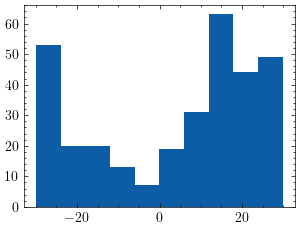

In [22]:
plt.figure()
plt.hist([i.angle for i in total_tasks])
plt.show()

In [23]:
import time
# # Timing...
times = []
totals = []
for i in tqdm(np.arange(4, 1032, 4)):
    t0 = time.time()
    t_coarse = int(i)
    total_tasks = get_total_tasks()
    t1 = time.time()
    times.append(t1 - t0)
    totals.append(len(total_tasks))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(4, 1032, 4), times)
plt.xscale("log",base=2)
plt.yscale("log")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.arange(4, 1032,4), totals)
plt.xscale("log",base=2)
plt.yscale("log")
plt.grid()
plt.show()

  2%|▏         | 4/257 [00:02<02:49,  1.49it/s]


KeyboardInterrupt: 

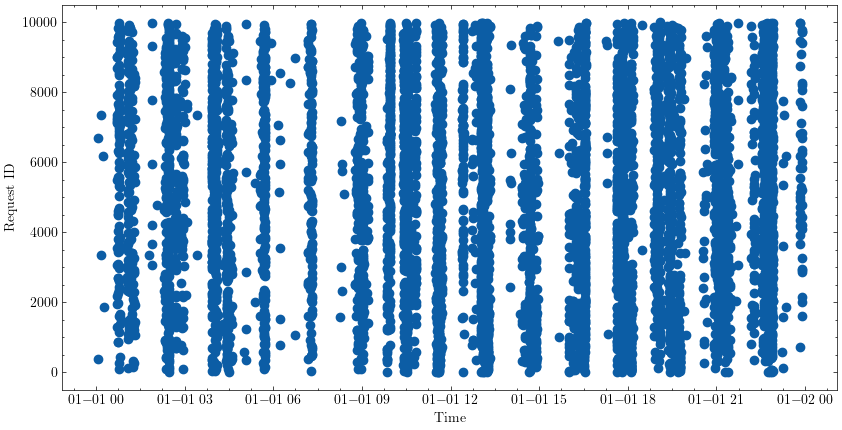

In [15]:
# Plot all task with request id
times = np.array([x.time for x in total_tasks])
task_ids = np.array([x.requestid for x in total_tasks])

plt.figure(figsize=(10, 5))
# for i in requests:
    # filter = [x.requestid == i.id for x in total_tasks]
plt.scatter(times, task_ids, label=f"Request {i}")

plt.ylabel("Request ID")
plt.xlabel("Time")
# plt.xlim((datetime.datetime(2024, 1, 2, 4, 0, 0), datetime.datetime(2024, 1, 2, 6, 0, 0)))
plt.show()

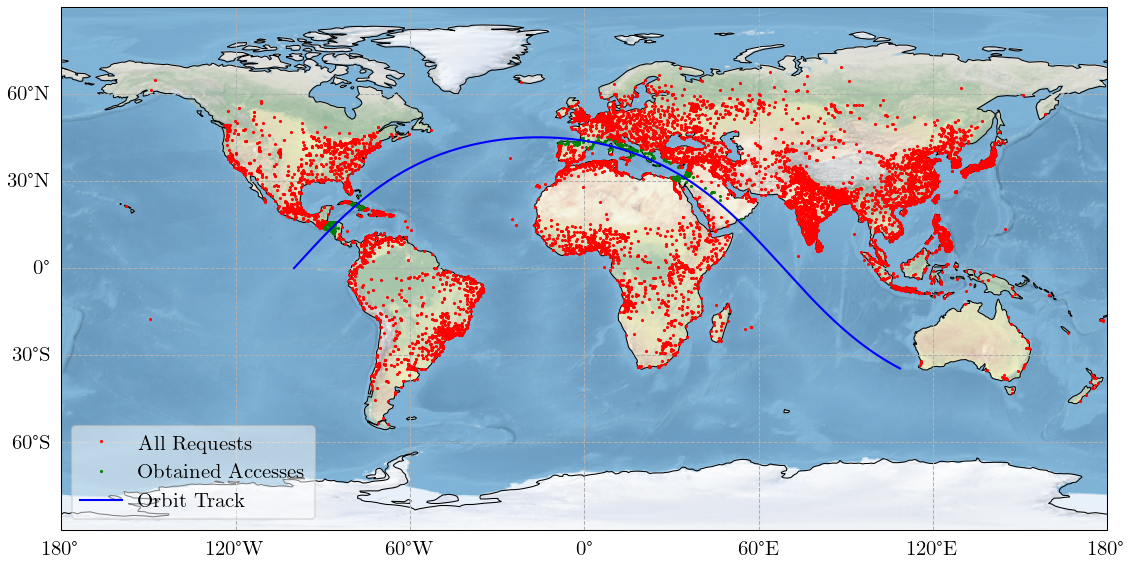

In [24]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features to the map
ax.stock_img()
# ax.add_feature(cfeature.LAND, facecolor='#A7C957')
# ax.add_feature(cfeature.OCEAN, facecolor='#A2D2FF')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False


access_latlongs = np.unique(np.array([[requests[x.requestid].lat, requests[x.requestid].long] for x in total_tasks]), axis=0)
req_latlongs = np.array([[x.lat, x.long] for x in requests if [x.lat, x.long] not in access_latlongs])

def split_orbit_track(latlongs, threshold=180):
    lat, long = np.array(latlongs)[:, 0], np.array(latlongs)[:, 1]
    # Calculate the difference between consecutive longitudes
    delta_long = np.abs(np.diff(long))
    
    # Identify where the jump exceeds the threshold
    jump_indices = np.where(delta_long > threshold)[0] + 1
    
    # Split the data at the jump indices
    segments = np.split(latlongs, jump_indices)
    return segments

ax.plot(req_latlongs[:, 1], req_latlongs[:, 0], '.r', markersize=1, label="All Requests", transform=ccrs.PlateCarree())
ax.plot(access_latlongs[:, 1], access_latlongs[:, 0], '.g', markersize=1, label="Obtained Accesses", transform=ccrs.PlateCarree())

segments = split_orbit_track([ecef2latlong(eci2ecef(kepler2eci(propagate_orbit(orbit, seconds_since_epoch + i))[0], t_0 + datetime.timedelta(seconds=i))) for i in range(0, int(1 * 3600), 1)])

for i, segment in enumerate(segments):
    if len(segment) == 0:
        continue  # Skip empty segments
    ax.plot(
        segment[:, 1],
        segment[:, 0],
        color='blue',
        label=f"Orbit Track" if i == 0 else None,
        transform=ccrs.PlateCarree()
    )

print()
# Plot orbit track
# orbit_track = np.array()
# plt.plot(orbit_track[:, 1], orbit_track[:, 0], label="Orbit Track")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(frameon=1, framealpha=0.5)
plt.show()

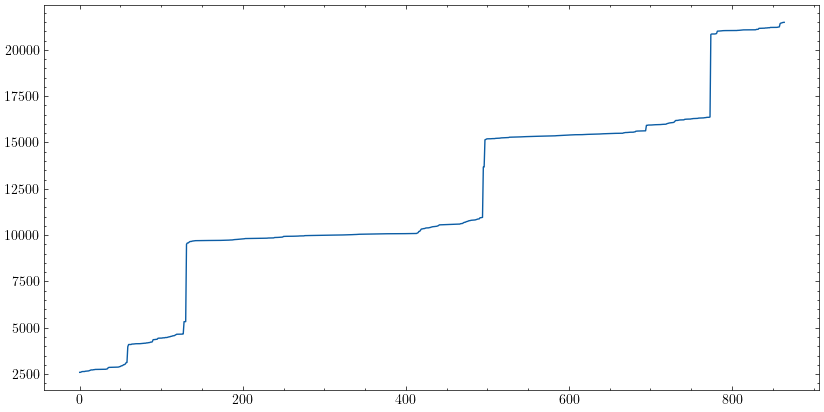

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(([(x.time - t_0).total_seconds() for x in total_tasks]))
plt.show()

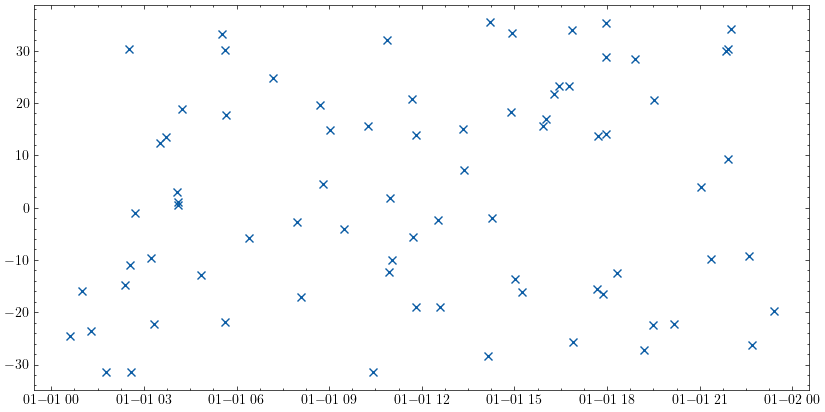

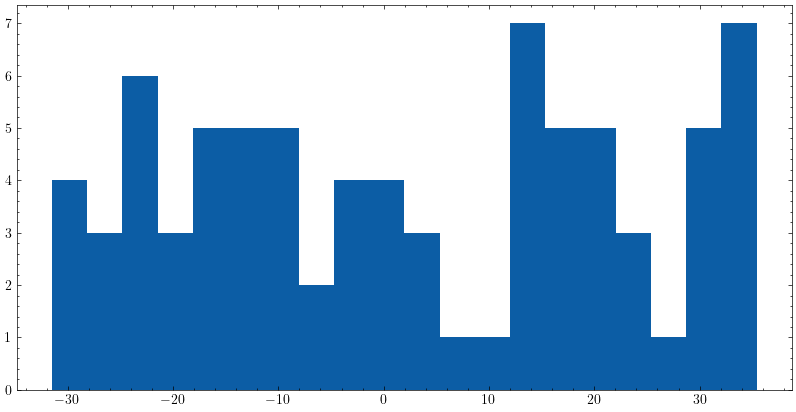

In [9]:
plt.figure(figsize=(10, 5))
plt.plot([x.time for x in total_tasks],[x.angle for x in total_tasks], 'x')
# plt.xlim((datetime.datetime(2024, 1, 2, 4, 0, 0), datetime.datetime(2024, 1, 2, 6, 0, 0)))
plt.show()

plt.figure(figsize=(10, 5))
plt.hist([x.angle for x in total_tasks], bins=20)
plt.show()

In [77]:
# Generate a greedy schedule
t_s = 60
t_dotsq = 16

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

def angle_time_constraint(angle, time):
    pass

np.random.seed(1)
occluded_mask = np.random.choice([0, 1], size=(len(total_tasks),), p=[1./3, 2./3])
def greedy_schedule(tasks, total_requests):
    schedule = []
    request_mask = np.zeros(len(requests))
    for i in tasks:
        if(len(schedule) == 0):
            schedule.append(i)
        else:
            if(request_mask[i.requestid] == 0 and i.time > datetime.timedelta(seconds=agility_bangbang(i.angle - schedule[-1].angle)) + schedule[-1].time):
                schedule.append(i)
                request_mask[i.requestid] = 1

    return schedule

def greedy_schedulerepair(schedule, total_tasks, allow_duplicates=False):
    schedule_copy = schedule.copy()
    request_mask = np.zeros(len(requests))
    for i in schedule:
        request_mask[i.requestid] = 1

    stop_iterating = False
    i = 0
    while(not stop_iterating):
        if(i == len(schedule_copy) - 1):
            break
        
        # Current node, looking ahead
        current = schedule_copy[i]
        next = schedule_copy[i + 1]
        next_next = schedule_copy[i + 2] if i + 2 < len(schedule_copy) else None

        total_index = total_tasks.index(next)
        if(occluded_mask[total_index] == 1):
            # Find the next non-occluded task
            next_nonoccluded = [x for x in total_tasks[i:] if occluded_mask[total_tasks.index(x)] == 0 and x.time > current.time]
            
            if(next_next):
                next_nonoccluded = [x for x in next_nonoccluded if x.time < next_next.time]

            if(len(next_nonoccluded) == 0):
                schedule_copy.pop(i)
                break

            for j in next_nonoccluded:
                if(j.time > datetime.timedelta(seconds=agility_bangbang(j.angle - current.angle)) + current.time and (next_next) and 
                    next_next.time > datetime.timedelta(seconds=agility_bangbang(next_next.angle - j.angle)) + j.time):
                    if(not allow_duplicates):
                        if(request_mask[j.requestid] == 1):
                            continue

                    schedule_copy.pop(i + 1)
                    schedule_copy.insert(i + 1, j)
                    request_mask[j.requestid] = 1

        i += 1

    return schedule_copy

tasks_nonoccluded = [x for i, x in enumerate(total_tasks) if occluded_mask[i] == 0]
tasks_occluded = [x for i, x in enumerate(total_tasks) if occluded_mask[i] == 1]

schedule = greedy_schedule(total_tasks, total_tasks)
schedule_omni = greedy_schedule(tasks_nonoccluded, total_tasks)

In [78]:
schedule_repaired = greedy_schedulerepair(schedule, total_tasks, allow_duplicates=False)

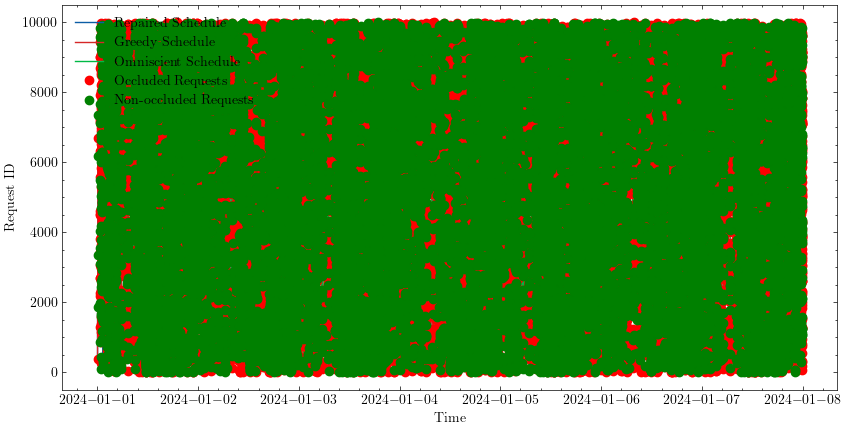

In [79]:
plt.figure(figsize=(10, 5))
# for i in requests:
    # filter = [x.requestid == i.id for x in total_tasks]
plt.plot([x.time for x in schedule_repaired], [x.requestid for x in schedule_repaired], '-',label="Repaired Schedule")
plt.plot([x.time for x in schedule], [x.requestid for x in schedule], '-',label="Greedy Schedule", color='tab:red')
plt.plot([x.time for x in schedule_omni], [x.requestid for x in schedule_omni], '-',label="Omniscient Schedule")
plt.plot([x.time for x in tasks_occluded], [x.requestid for x in tasks_occluded], 'or', label="Occluded Requests")
plt.plot([x.time for x in tasks_nonoccluded], [x.requestid for x in tasks_nonoccluded], 'og', label="Non-occluded Requests")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Request ID")
plt.show()

In [80]:
# Calculate non-occluded tasks
def get_nonoccluded_count(schedule, occluded_mask, total_tasks):
    nonoccluded_count = 0
    for i in schedule:
        if(occluded_mask[total_tasks.index(i)] == 0):
            nonoccluded_count += 1

    return nonoccluded_count
    

# Calculate number of total tasks
print(f"Total Tasks in Schedule: Greedy: {len(schedule)}, Repaired: {len(schedule_repaired)}, Omniscient: {len(schedule_omni)}")
print(f"Total Non-Occluded Tasks in Schedule: Greedy: {get_nonoccluded_count(schedule, occluded_mask, total_tasks)}, Repaired: {get_nonoccluded_count(schedule_repaired, occluded_mask, total_tasks)}, Omniscient: {get_nonoccluded_count(schedule_omni, occluded_mask, total_tasks)}")
print(f"Proportion Non-Occluded in Schedule: Greedy: {100 * get_nonoccluded_count(schedule, occluded_mask, total_tasks) / len(schedule):.2f}%, Repaired: {100 * get_nonoccluded_count(schedule_repaired, occluded_mask, total_tasks) / len(schedule_repaired):.2f}%, Omniscient: {100*get_nonoccluded_count(schedule_omni, occluded_mask, total_tasks) / len(schedule_omni):.2f}%")

Total Tasks in Schedule: Greedy: 1481, Repaired: 1480, Omniscient: 1241
Total Non-Occluded Tasks in Schedule: Greedy: 465, Repaired: 468, Omniscient: 1241
Proportion Non-Occluded in Schedule: Greedy: 31.40%, Repaired: 31.62%, Omniscient: 100.00%
